In [1]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, \
    WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, \
    RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep

In [2]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)
images.shape, labels.shape

((300, 1, 5, 5), (300,))

In [3]:
def plot_images(images, labels, n_plots=30):
    n_rows = n_plots // 6 + ((n_plots % 6) > 0)
    fig, axes = plt.subplots(nrows=n_rows, ncols=6, figsize=(9, 1.5 * n_rows))
    np.atleast_2d(axes)

    for i, (x, y) in enumerate(zip(images[:n_plots], labels[:n_plots])):
        row, col = (i//6), (i % 6)
        ax = axes[row, col]
        ax.set_title(f"#{i} - Label:{y}", {"size": 12})
        ax.imshow(x.squeeze(), cmap="gray", vmin=0, vmax=1)

    for axis in axes.flat:
        axis.set_xticks([])
        axis.set_yticks([])
        axis.label_outer()

    plt.tight_layout()
    return fig

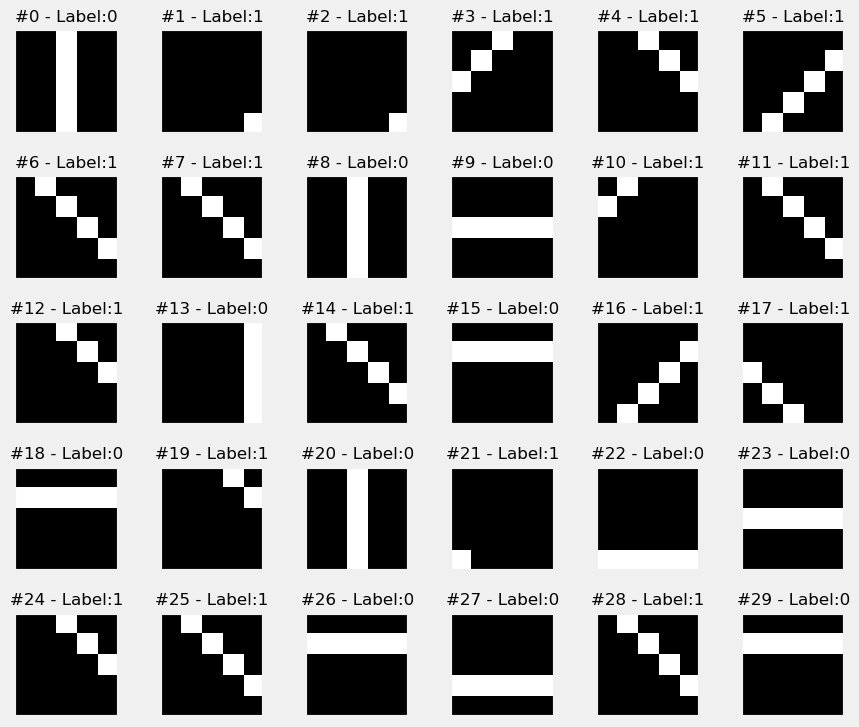

In [4]:
fig = plot_images(images, labels, 30)

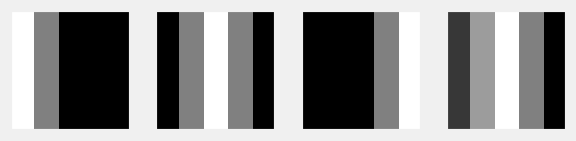

In [5]:
image_r = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128

image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128

image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255

image_gray = .2126 * image_r + .7152*image_g + .0722 * image_b

fig, axes = plt.subplots(1, 4)
axes[0].imshow(image_r, cmap='gray')
axes[1].imshow(image_g, cmap='gray')
axes[2].imshow(image_b, cmap='gray')
axes[3].imshow(image_gray, cmap='gray')

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.label_outer()

plt.show()

([], [])

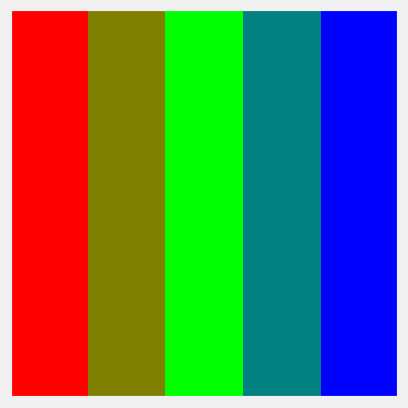

In [6]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2)
plt.imshow(image_rgb)
plt.xticks([])
plt.yticks([])

In [7]:
example = images[7]
example

array([[[  0, 255,   0,   0,   0],
        [  0,   0, 255,   0,   0],
        [  0,   0,   0, 255,   0],
        [  0,   0,   0,   0, 255],
        [  0,   0,   0,   0,   0]]], dtype=uint8)

In [8]:
example_hwc = np.transpose(example, axes=(1, 2, 0))
example_hwc.shape

(5, 5, 1)

In [9]:
tensorizer = ToTensor()
exmaple_tensor = tensorizer(example_hwc)
exmaple_tensor.shape

torch.Size([1, 5, 5])

In [10]:
exmaple_tensor

tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])

In [11]:
example_img = ToPILImage()(exmaple_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


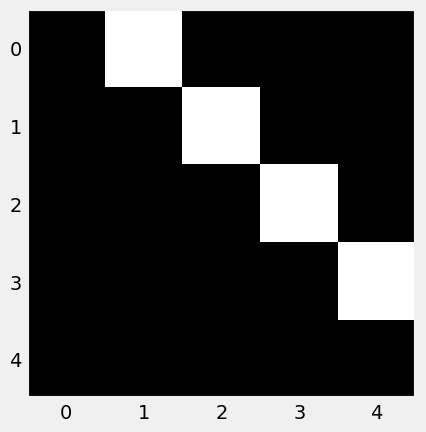

In [12]:
plt.imshow(example_img, cmap='gray')
plt.grid(False)

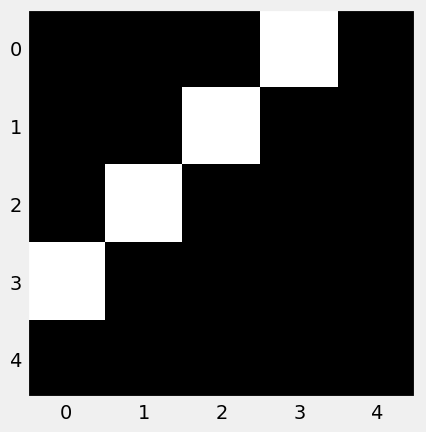

In [13]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)
plt.imshow(flipped_img, cmap='gray')
plt.grid(False)

In [14]:
img_tensor = tensorizer(flipped_img)
img_tensor

tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])

In [15]:
normalizer = Normalize(mean=(.5,), std=(.5,))
normalized_tensor = normalizer(img_tensor)
normalized_tensor

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])

In [16]:
composer = Compose([RandomHorizontalFlip(p=1.0), Normalize(mean=(.5,), std=(.5,))])

In [17]:
composed_tensor = composer(exmaple_tensor)
(composed_tensor == normalized_tensor).all()

tensor(True)

In [18]:
# 拆分之前从Numpy数组中构建的张量
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

x_tensor, images

(tensor([[[[0., 0., 1., 0., 0.],
           [0., 0., 1., 0., 0.],
           [0., 0., 1., 0., 0.],
           [0., 0., 1., 0., 0.],
           [0., 0., 1., 0., 0.]]],
 
 
         [[[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 1.]]],
 
 
         [[[0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 1.]]],
 
 
         ...,
 
 
         [[[0., 0., 0., 1., 0.],
           [0., 0., 1., 0., 0.],
           [0., 1., 0., 0., 0.],
           [1., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0.]]],
 
 
         [[[0., 0., 0., 1., 0.],
           [0., 0., 0., 1., 0.],
           [0., 0., 0., 1., 0.],
           [0., 0., 0., 1., 0.],
           [0., 0., 0., 1., 0.]]],
 
 
         [[[0., 0., 0., 1., 0.],
           [0., 0., 1., 0., 0.],
           [0., 1., 0., 0., 0.],
           [1., 0., 0., 0., 

In [19]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        super().__init__()
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]

        if self.transform is not None:
            x = self.transform(x)
        return x, self.y[index]
    
    def __len__(self):
        return len(self.x)

In [20]:
composer = Compose([RandomHorizontalFlip(p=0.5), Normalize(mean=(.5,), std=(.5,))])

dataset = TransformedTensorDataset(x_tensor, y=y_tensor, transform=composer)

In [21]:
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # 使拆分的参数成为张量
    splits_tensor = torch.as_tensor(splits)
    # 找到正确的乘数
    # 所以不必担心求和为N(或1)
    multiplier = n / splits_tensor.sum()
    splits_tensor = (multiplier * splits_tensor).long()
    # 如果有差异，则在第一个拆分处抛出异常
    # 以避免random_split抱怨
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff

    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [22]:
train_idx, val_idx = index_splitter(len(dataset), splits=[80, 20])
train_idx

In [23]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(dataset, batch_size=16, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=16, sampler=val_sampler)

len(iter(train_loader)), len(iter(val_loader))

(15, 4)

In [24]:
# 使用索引执行拆分
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

train_composer = Compose([RandomHorizontalFlip(p=0.5), Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])

train_set = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_set = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

In [25]:
# WeightedRandomSampler
classes, counts = y_train_tensor.unique(return_counts=True)
classes, counts

(tensor([0., 1.]), tensor([ 80, 160]))

In [26]:
weights = 1. / counts.float()
weights

tensor([0.0125, 0.0063])

In [27]:
sample_weights = weights[y_train_tensor.squeeze().long()]
print(sample_weights.shape)
print(sample_weights[:10])
print(y_train_tensor[:10].squeeze())

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])


In [28]:
generator = torch.Generator()

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    generator=generator,
    replacement=True
)

In [29]:
train_loader = DataLoader(train_set, batch_size=16, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=16)

In [30]:
def make_balanced_sampler(y):
    _, counts = y.unique(return_counts=True)
    weights = 1. / counts.float()
    sample_weights = weights[y.squeeze().long()]
    
    generator = torch.Generator()
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )

In [31]:
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

train_idx, val_idx = index_splitter(len(x_tensor), splits=[80, 20])

x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

train_composer = Compose([RandomHorizontalFlip(p=0.5), Normalize(mean=(.5,), std=(.5, ))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5, ))])

train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

train_loader = DataLoader(train_dataset, batch_size=16, sampler=make_balanced_sampler(y_train_tensor))
val_loader = DataLoader(val_dataset, batch_size=16)

In [32]:
lr = 0.1

torch.manual_seed(17)
model_logistic = nn.Sequential()
model_logistic.add_module("flatten", nn.Flatten())
model_logistic.add_module("output", nn.Linear(25, 1, bias=False))
model_logistic.add_module("sigmoid", nn.Sigmoid())

optimizer_logistic = optim.SGD(model_logistic.parameters(), lr=lr)

binary_loss_fn = nn.BCELoss()

In [33]:
n_epochs = 100

sbs_logistic = StepByStep(model_logistic, binary_loss_fn, optimizer_logistic)
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

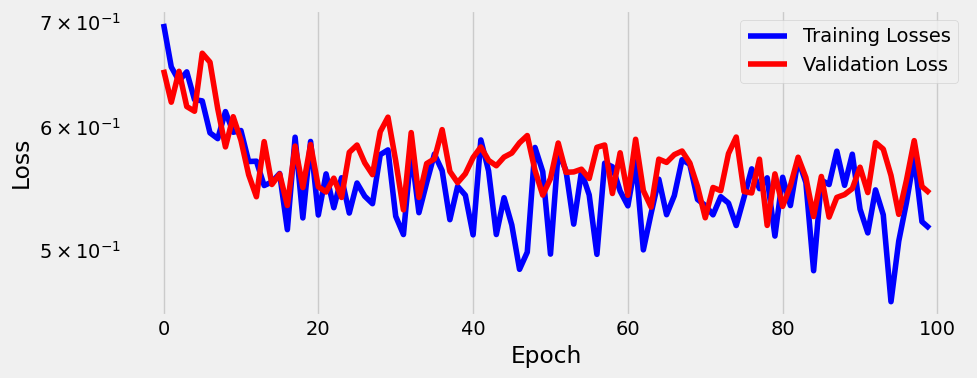

In [34]:
fig = sbs_logistic.plot_losses()

In [35]:
lr = 0.1

torch.manual_seed(17)
model_nn = nn.Sequential()
model_nn.add_module("flatten", nn.Flatten())
model_nn.add_module("hidden0", nn.Linear(25, 5, bias=False))
model_nn.add_module("hidden1", nn.Linear(5, 3, bias=False))
model_nn.add_module("output", nn.Linear(3, 1, bias=False))
model_nn.add_module("sigmoid", nn.Sigmoid())

optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

binary_loss_fn = nn.BCELoss()

n_epochs = 100

sbs_nn = StepByStep(model_nn, binary_loss_fn, optimizer_nn)
sbs_nn.set_loaders(train_loader, val_loader)
sbs_nn.train(n_epochs)

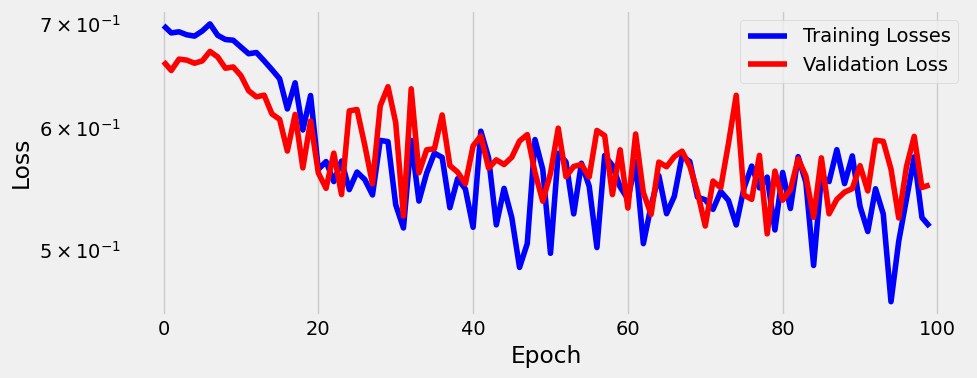

In [36]:
fig = sbs_nn.plot_losses()

In [37]:
sbs_logistic.count_parameters(), sbs_nn.count_parameters()

(25, 143)

In [38]:
lr = 0.1

torch.manual_seed(17)
model_relu = nn.Sequential()
model_relu.add_module("flatten", nn.Flatten())
model_relu.add_module("hidden0", nn.Linear(25, 5, bias=False))
model_relu.add_module("activation0", nn.ReLU())
model_relu.add_module("hidden1", nn.Linear(5, 3, bias=False))
model_relu.add_module("activation1", nn.ReLU())
model_relu.add_module("output", nn.Linear(3, 1, bias=False))
model_relu.add_module("sigmoid", nn.Sigmoid())

optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

binary_loss_fn = nn.BCELoss()

n_epochs = 100

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

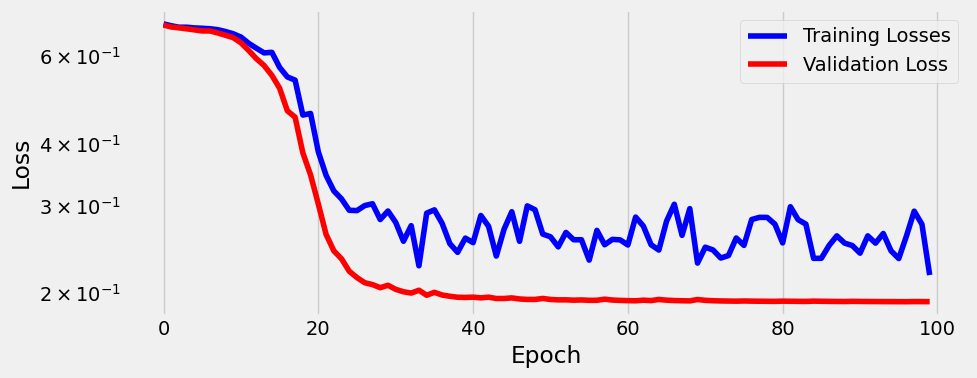

In [39]:
fig = sbs_relu.plot_losses()